In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, Input
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/X_train.npy')
y_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/y_train.npy')
X_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/X_test.npy')
y_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/y_test.npy')
X_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/X_val.npy')
y_val = np.load('/content/gdrive/MyDrive/Colab Notebooks/FYP/WaveletTransformDenoised/y_val.npy')

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(16893, 98) (16893, 2)
(2109, 98) (2109, 2)
(2088, 98) (2088, 2)


In [ ]:
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Conv1D, MaxPooling1D, Activation
from keras.layers import Reshape, Softmax, Permute, Multiply, dot, concatenate
from keras.layers import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K

inputs = Input(shape=(98,1))
conv1 = Conv1D(64, 5, activation='relu')(inputs)
pool1 = MaxPooling1D(2)(conv1)
conv2 = Conv1D(32, 5, activation='relu')(pool1)
pool2 = MaxPooling1D(2)(conv2)
conv3 = Conv1D(64, 5, activation='relu')(pool2)
pool3 = MaxPooling1D(2)(conv3)

gru1 = GRU(128)(pool3)
reshaped = Reshape((-1, K.int_shape(pool3)[-1]))(gru1)
permuted = Permute((2, 1))(reshaped)
gru2 = GRU(64)(permuted)


q = Dense(128)(gru2)
k = Dense(128)(gru2)
v = Dense(128)(gru2)

q = Reshape((1, 128))(q)
k = Reshape((1, 128))(k)
v = Reshape((1, 128))(v)

attention = dot([q, k], axes=[2, 2])
attention = Activation('softmax')(attention)

output = dot([attention, v], axes=[2, 1])
output = Reshape((128,))(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)

output = Dense(2, activation='softmax')(output)

model = Model(inputs=inputs, outputs=output)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 98, 1)]      0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 94, 64)       384         ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 47, 64)      0           ['conv1d_9[0][0]']               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 43, 32)       10272       ['max_pooling1d_6[0][0]']        
                                                                                            

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(amsgrad=True),
    metrics=['accuracy']
)

In [ ]:
print("Model Score: \n")
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 120)

Model Score: 

Epoch 1/120
528/528 [==============================] - 15s 12ms/step - loss: 0.3820 - accuracy: 0.8292 - val_loss: 0.3730 - val_accuracy: 0.8391
Epoch 2/120
528/528 [==============================] - 7s 13ms/step - loss: 0.2116 - accuracy: 0.9209 - val_loss: 0.4274 - val_accuracy: 0.8309
Epoch 3/120
528/528 [==============================] - 5s 10ms/step - loss: 0.1877 - accuracy: 0.9307 - val_loss: 0.1683 - val_accuracy: 0.9382
Epoch 4/120
528/528 [==============================] - 6s 12ms/step - loss: 0.1694 - accuracy: 0.9361 - val_loss: 0.1681 - val_accuracy: 0.9353
Epoch 5/120
528/528 [==============================] - 6s 11ms/step - loss: 0.1572 - accuracy: 0.9435 - val_loss: 0.1673 - val_accuracy: 0.9425
Epoch 6/120
528/528 [==============================] - 6s 10ms/step - loss: 0.1472 - accuracy: 0.9442 - val_loss: 0.1533 - val_accuracy: 0.9425
Epoch 7/120
528/528 [==============================] - 7s 12ms/step - loss: 0.1327 - accuracy: 0.9511 - val_loss: 0.1402

In [ ]:
model.save("/content/gdrive/MyDrive/Colab Notebooks/Experiments/CRNN_GRU_GRU_NoExtraDense_WithAttention-Lite.h5")
score = model.evaluate(X_test, y_test)
print(score)

66/66 [==============================] - 0s 6ms/step - loss: 0.1762 - accuracy: 0.9839
[0.17624244093894958, 0.9838786125183105]


In [ ]:
pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9470 sha256=b95a099ccbe898384bec9c9150c2734f1c9564d4916b190bcdda3bbf06ba772b
  Stored in directory: /root/.cache/pip/wheels/aa/0a/0f/0775c812151040fb695c0890d902810a9d69e1db50181e5328
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320515 sha256=a4ddb7149ca8ae75daf38bf2aa938a4016e2bddda3f5c1a2718e0fec82976d14
  Stored in directory: /root/.cache/pip/wheels/d2/50/d6/95e7c7713c3c1609e30a394d7431ffc11e4f7deb82d13ffceb
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

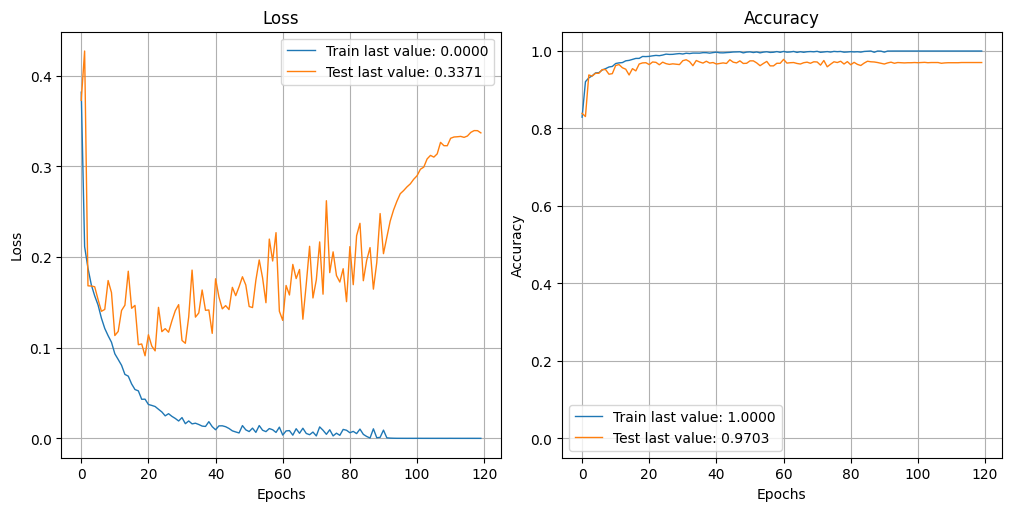

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
plot_history(history)

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Model Classification Report: 

66/66 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1049
           1       0.99      0.98      0.98      1060

    accuracy                           0.98      2109
   macro avg       0.98      0.98      0.98      2109
weighted avg       0.98      0.98      0.98      2109

Confusion matrix, without normalization
[[1034   15]
 [  19 1041]]


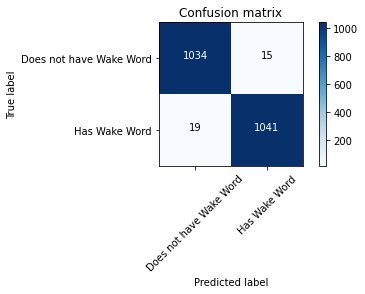

In [ ]:
print("Model Classification Report: \n")
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(classification_report(np.argmax(y_test, axis=1), y_pred))
plot_confusion_matrix(cm, classes=["Does not have Wake Word", "Has Wake Word"])